In [4]:
import torch
import joblib
import numpy as np
from torch import nn
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm
from data.data_loader import DroneGraphDataset
from models.pretrained_model_loader import (
    load_pretrained_traj_model,
    extract_context_embeddings,
    extract_decoder_embeddings,
)
from models.tgn import DroneRelationModel

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DroneGraphDataset(
    trajectory_csv="data/drone_states.csv",
    relationship_csv="data/drone_relations.csv",
    lookback=50,
    device=device,
)

sample = dataset[0]
print(sample["context_window"].shape)  # [50, num_drones, 4]
print(sample["current_features"].shape)  # [num_drones, 4]
print(sample["relationships"].shape)  # [num_pairs, 2]
# print(sample['labels'].shape)            # [num_pairs]


[Skipping] Flight 0, timestep 29.7 has 5 drones
[Skipping] Flight 1, timestep 32.6 has 1 drones
[Skipping] Flight 2, timestep 31.467 has 3 drones
[Skipping] Flight 3, timestep 29.4 has 1 drones
[Skipping] Flight 4, timestep 26.967 has 3 drones
[Skipping] Flight 5, timestep 33.767 has 1 drones
[Skipping] Flight 6, timestep 30.6 has 3 drones
[Skipping] Flight 7, timestep 35.7 has 3 drones
[Skipping] Flight 8, timestep 35.067 has 2 drones
[Skipping] Flight 9, timestep 30.067 has 4 drones
[Skipping] Flight 10, timestep 35.933 has 4 drones
[Skipping] Flight 11, timestep 32.5 has 2 drones
[Skipping] Flight 13, timestep 30.167 has 3 drones
[Skipping] Flight 14, timestep 35.633 has 5 drones
[Skipping] Flight 15, timestep 37.367 has 2 drones
[Skipping] Flight 16, timestep 31.833 has 5 drones
[Skipping] Flight 17, timestep 34.8 has 1 drones
[Skipping] Flight 18, timestep 31.033 has 3 drones
[Skipping] Flight 21, timestep 35.1 has 5 drones
[Skipping] Flight 22, timestep 30.2 has 1 drones
[Skippin

In [6]:
# Example usage
experiment_dir = Path("experiments/20251101_053057")

# Load model + config
model, config = load_pretrained_traj_model(experiment_dir, device)

# Load scalers
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Dummy trajectory data (replace with your actual drone trajectory segment)
dummy_data = np.random.rand(100, 6 * 3).astype(
    np.float32
)  # 100 timesteps, 6 drones, xyz

# Extract embeddings
context_emb = extract_context_embeddings(
    model,
    traj_data=dummy_data,
    scaler_X=scaler_X,
    lookback=config["LOOK_BACK"],
    features_per_agent=6,
    device=device,
)

print("Context embeddings shape:", context_emb.shape)

Context embeddings shape: torch.Size([3, 128])


In [7]:
from torch.utils.data import Subset

flight_ids = dataset.flights
num_train = int(0.8 * len(flight_ids))
train_flights = flight_ids[:num_train]
test_flights = flight_ids[num_train:]

train_indices = [
    i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in train_flights
]
test_indices = [
    i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in test_flights
]

train_ds = Subset(dataset, train_indices)
test_ds = Subset(dataset, test_indices)

In [8]:
def balance_pairs(relationships, labels, max_neg_per_pos=1):
    """
    Undersample negative pairs so the ratio between negatives and positives
    is roughly `max_neg_per_pos` : 1.
    """
    pos_mask = labels == 1
    neg_mask = labels == 0

    pos_indices = torch.nonzero(pos_mask).squeeze(1)
    neg_indices = torch.nonzero(neg_mask).squeeze(1)

    num_pos = len(pos_indices)
    num_neg = len(neg_indices)
    if num_pos == 0 or num_neg == 0:
        return relationships, labels  # skip balancing if only one class

    # Sample negatives
    num_keep_neg = min(num_neg, num_pos * max_neg_per_pos)
    sampled_neg_indices = neg_indices[torch.randperm(num_neg)[:num_keep_neg]]

    # Combine and shuffle
    keep_indices = torch.cat([pos_indices, sampled_neg_indices])
    keep_indices = keep_indices[torch.randperm(len(keep_indices))]

    return relationships[keep_indices], labels[keep_indices]

In [9]:
def train_epoch(
    model, loader, optimizer, criterion, scaler_X, pretrained_model, config
):
    model.train()
    pretrained_model.train()
    total_loss = 0
    for batch in tqdm(
        loader, desc="Training", leave=True, ncols=100, dynamic_ncols=True
    ):
        context_window = (
            batch["context_window"].squeeze(0).to(device)
        )  # [50, num_drones, 4]
        current_features = batch["current_features"].squeeze(0).to("cpu")
        relationships = batch["relationships"].squeeze(0).to("cpu")
        labels = batch["labels"].squeeze(0).float().to("cpu")

        # # --- New: target indices per friendly drone ---
        # target_indices = batch["target_indices"].squeeze(0).to(device)  # [num_friendly]

        # num_friendly = batch["num_friendly"]
        # num_unauth = batch["num_unauth"]

        relationships, labels = balance_pairs(relationships, labels, max_neg_per_pos=1)
        # relationships = batch["relationships"].squeeze(0).to(device)

        # Extract context embeddings from pretrained model
        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :6].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=6,
            device="cpu",
        )

        preds = model(current_features, context_emb, relationships)
        loss = criterion(preds, labels)

        # probs, logits = model(current_features, context_emb, relationships, num_friendly, num_unauth)
        # loss = criterion(logits, target_indices)  # logits: [num_friendly, num_unauth]

        # custom weighting
        # weights = torch.where(labels == 1, 2.0, 1.0)  # higher weight for 1s
        # loss = (weights * loss).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [10]:
# from models.vgae import GCNLayer, VGAE, reconstruction_loss, kl_divergence, build_adj_from_pairs
# from tqdm import tqdm

# # --- TRAINING LOOP ---
# def train_epoch_vgae(vgae_model, loader, optimizer, scaler_X, pretrained_model, config, device="cpu"):
#     vgae_model.train()
#     pretrained_model.train()
#     total_loss = 0.0

#     for batch in tqdm(loader, desc="Training", leave=True, ncols=100, dynamic_ncols=True):
#         context_window = batch["context_window"].squeeze(0).to(device)  # [T, N, 4]
#         relationships = batch["relationships"].squeeze(0).to(device)
#         labels = batch["labels"].squeeze(0).float().to(device)

#         relationships, labels = balance_pairs(relationships, labels, max_neg_per_pos=1)

#         # === 1. Extract context embeddings ===
#         context_emb = extract_decoder_embeddings(
#             pretrained_model,
#             traj_data=context_window[:, :, :3].reshape(context_window.shape[0], -1),
#             scaler_X=scaler_X,
#             lookback=config["LOOK_BACK"],
#             features_per_agent=3,
#             device=device,
#         )  # [num_drones, hidden_dim]

#         num_nodes = context_emb.size(0)
#         adj = build_adj_from_pairs(num_nodes, relationships, labels, directed=True, self_loops=True, device=device)

#         # === 2. Forward VGAE ===
#         scores, mu, logvar = vgae_model(context_emb, adj)

#         # === 3. Compute losses ===
#         recon_loss = reconstruction_loss(scores, adj)
#         kld = kl_divergence(mu, logvar)
#         loss = recon_loss + kld  # (you can scale kld if needed, e.g., loss = recon_loss + 0.1 * kld)

#         # === 4. Backprop ===
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(loader)

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)


@torch.no_grad()
def evaluate(model, loader, scaler_X, pretrained_model, config, show_confusion=True):
    model.eval()
    pretrained_model.eval()
    preds_all, labels_all = [], []
    inspected = 0
    inspect_n = 9

    for batch in tqdm(
        loader, desc="Evaluating", leave=True, ncols=100, dynamic_ncols=True
    ):
        context_window = batch["context_window"].squeeze(0).cpu().numpy()
        current_features = batch["current_features"].squeeze(0).to("cpu")
        labels = batch["labels"].squeeze(0).float().to("cpu")
        relationships = batch["relationships"].squeeze(0).to(device)

        # target_indices = batch["target_indices"].squeeze(0).to("cpu")
        # num_friendly = batch["num_friendly"]
        # num_unauth = batch["num_unauth"]

        context_emb = extract_decoder_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :6].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=6,
            device=device,
        )

        preds = model(current_features, context_emb, relationships)
        # preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities

        # probs, logits = model(current_features, context_emb, relationships, num_friendly, num_unauth)

        # Predicted unauthorized drone per friendly
        # pred_indices = torch.argmax(probs, dim=1)

        preds_all.append(preds)
        labels_all.append(labels)

        # Inspect first few data points
        if inspected < inspect_n:
            print(
                f"Predicted logits: {preds[:inspect_n].detach().cpu().numpy().flatten()}"
            )
            print(
                f"Actual labels: {labels[:inspect_n].detach().cpu().numpy().flatten()}"
            )

            inspected += 1

    preds_all = torch.cat(preds_all)
    labels_all = torch.cat(labels_all)

    print(preds_all.min().item(), preds_all.max().item())
    print(labels_all.min().item(), labels_all.max().item())

    # Binary predictions
    y_true = labels_all.cpu().numpy().astype(int)
    y_pred = (preds_all.cpu().numpy() > 0.8).astype(int)

    # Compute accuracy
    acc = (y_true == y_pred).mean().item()

    # Compute accuracy
    # acc = (preds_all == labels_all).float().mean().item()
    # print(f"Accuracy: {acc:.3f}")
    
    # Optional: print precision/recall/F1
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    # compute ROC AUC and ROC curve
    try:
        auc = roc_auc_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
    except ValueError:
        auc = np.nan
        fpr, tpr = [0, 1], [0, 1]  # fallback for degenerate cases

    print(f"Accuracy: {acc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")  # >>> CHANGED

    if show_confusion:
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
        disp.plot(cmap="Blues", colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()
        
        # >>> ADDED: ROC curve
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

        # >>> ADDED: Precision–Recall curve
        precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
        plt.figure(figsize=(5, 5))
        plt.plot(recalls, precisions)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve")
        plt.grid(True)
        plt.show()


    # if show_confusion:
    #     y_true = labels_all.cpu().numpy()
    #     y_pred = preds_all.cpu().numpy()
    #     cm = confusion_matrix(y_true, y_pred, labels=list(range(num_unauth)))
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #     disp.plot(cmap="Blues", colorbar=False)
    #     plt.title("Confusion Matrix")
    #     plt.show()

    #     # Optional: print precision/recall/F1 (micro-averaged)
    #     precision = precision_score(y_true, y_pred, average="micro", zero_division=0)
    #     recall = recall_score(y_true, y_pred, average="micro", zero_division=0)
    #     f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    #     print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    return acc

In [12]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# # --- EVALUATION LOOP ---
# @torch.no_grad()
# def evaluate_vgae(vgae_model, loader, scaler_X, pretrained_model, config, device="cpu", show_confusion=True):
#     vgae_model.eval()
#     pretrained_model.eval()
#     preds_all, labels_all = [], []

#     for batch in tqdm(loader, desc="Evaluating", leave=True, ncols=100, dynamic_ncols=True):
#         context_window = batch["context_window"].squeeze(0).to(device)
#         relationships = batch["relationships"].squeeze(0).to(device)
#         labels = batch["labels"].squeeze(0).float().to(device)

#         # === 1. Extract context embeddings ===
#         context_emb = extract_decoder_embeddings(
#             pretrained_model,
#             traj_data=context_window[:, :, :3].reshape(context_window.shape[0], -1),
#             scaler_X=scaler_X,
#             lookback=config["LOOK_BACK"],
#             features_per_agent=3,
#             device=device,
#         )

#         num_nodes = context_emb.size(0)
#         adj_true = build_adj_from_pairs(num_nodes, relationships, labels, directed=True, self_loops=True, device=device)

#         # === 2. VGAE forward ===
#         scores, mu, logvar = vgae_model(context_emb, adj_true)
#         adj_pred = torch.sigmoid(scores)

#         # Extract predictions for given relationships
#         preds = adj_pred[relationships[:, 0], relationships[:, 1]]
#         preds_all.append(preds)
#         labels_all.append(labels)

#     preds_all = torch.cat(preds_all)
#     labels_all = torch.cat(labels_all)

#     print(preds_all.min().item(), preds_all.max().item())
#     print(labels_all.min().item(), labels_all.max().item())

#     # === 3. Compute metrics ===
#     y_true = labels_all.cpu().numpy().astype(int)
#     y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

#     acc = (y_true == y_pred).mean().item()

#     if show_confusion:
#         cm = confusion_matrix(y_true, y_pred)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
#         disp.plot(cmap="Blues", colorbar=False)
#         plt.title("Confusion Matrix")
#         plt.show()

#         precision = precision_score(y_true, y_pred, zero_division=0)
#         recall = recall_score(y_true, y_pred, zero_division=0)
#         f1 = f1_score(y_true, y_pred, zero_division=0)
#         print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

#     return acc

Evaluating:   0%|          | 13/5068 [00:00<01:25, 59.44it/s]

Predicted logits: [0.7655875  0.5279023  0.75989467 0.7083041  0.4558558  0.69279677
 0.63262564 0.72131366 0.5570239 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7660566  0.52845174 0.76071787 0.7076     0.45499983 0.6923544
 0.6310915  0.7215551  0.555227  ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.76616645 0.52815604 0.76125246 0.7057835  0.4523025  0.6907979
 0.6311771  0.721389   0.5544599 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7660113  0.5276694  0.7613809  0.70377123 0.44897172 0.68897486
 0.6331792  0.72094333 0.556055  ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7654898  0.5265738  0.7606052  0.7019797  0.44548893 0.6869344
 0.6356268  0.719769   0.5601376 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.76459086 0.52457166 0.7591068  0.69971174 0.4413456  0.68401074
 0.63813365 0.71774346 0.56543964]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [

Evaluating: 100%|██████████| 5068/5068 [01:22<00:00, 61.61it/s]


5.951058028585976e-07 0.935619056224823
0.0 1.0
Accuracy: 0.694, Precision: 0.857, Recall: 0.098, F1: 0.176, AUC: 0.545


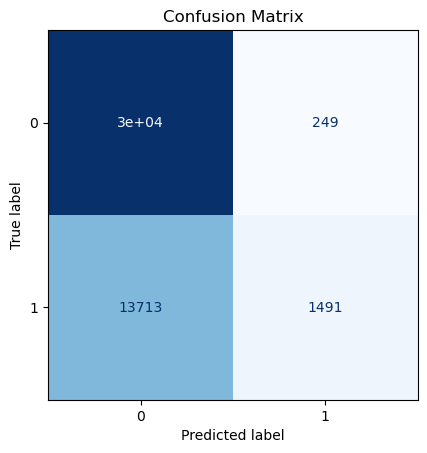

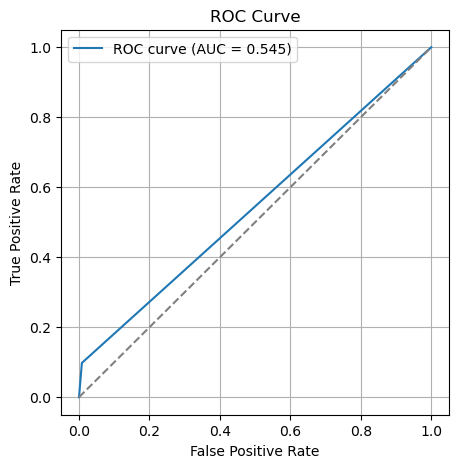

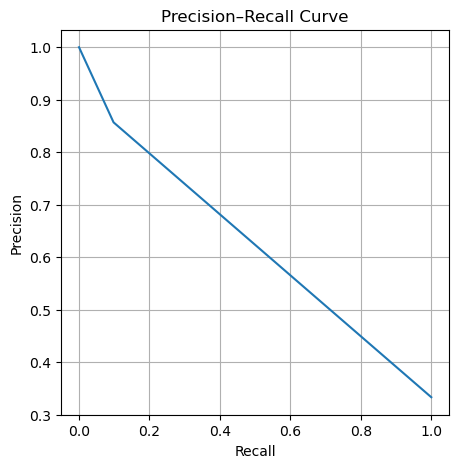

Epoch 1: Loss=0.5599, Test Acc=0.694


Evaluating:   0%|          | 13/5068 [00:00<01:23, 60.28it/s]

Predicted logits: [0.790081   0.5245405  0.8311432  0.72991145 0.42319646 0.7593114
 0.6708091  0.75917685 0.7111781 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.79092133 0.5251057  0.8326712  0.7297781  0.42225975 0.7599601
 0.66995007 0.7596001  0.71084017]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7906939  0.5242848  0.83363974 0.72781146 0.4191531  0.7592316
 0.66984    0.75917524 0.7107126 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7895512  0.5229809  0.8336147  0.72424823 0.41502663 0.7569654
 0.6703154  0.7581967  0.71115184]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7879009  0.52060604 0.83185774 0.7198537  0.40990332 0.7526435
 0.67030126 0.75614965 0.7118772 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.78578115 0.5168497  0.82886356 0.71480036 0.4034474  0.746599
 0.6699191  0.75288224 0.7126332 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.78

Evaluating: 100%|██████████| 5068/5068 [01:26<00:00, 58.82it/s]

3.1520610264124116e-06 0.9779420495033264
0.0 1.0
Accuracy: 0.722, Precision: 0.803, Recall: 0.220, F1: 0.345, AUC: 0.597


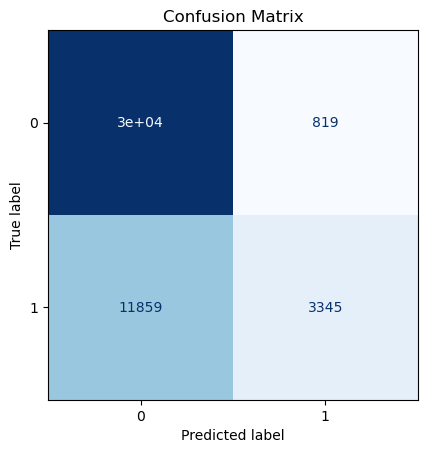

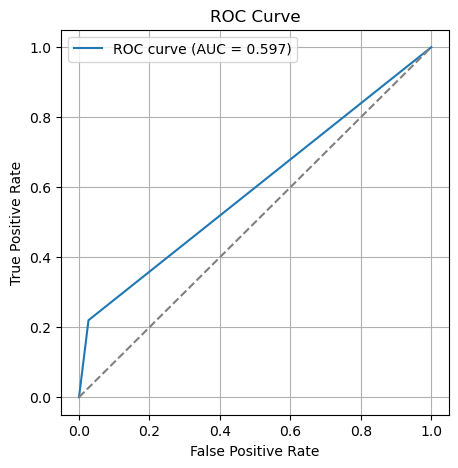

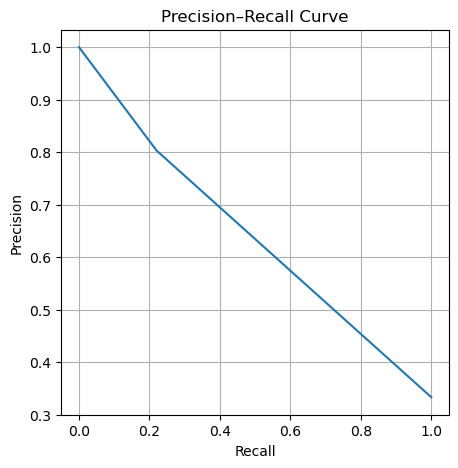

Epoch 2: Loss=0.4715, Test Acc=0.722


Evaluating:   0%|          | 12/5068 [00:00<01:26, 58.36it/s]

Predicted logits: [0.77361274 0.5978294  0.8556035  0.74429727 0.5344102  0.81307447
 0.663965   0.7840483  0.7505947 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7746218  0.5985131  0.8573413  0.74409086 0.53330356 0.81385905
 0.6636265  0.7845715  0.7491844 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.7744414  0.59775347 0.8585898  0.74218124 0.5300027  0.81358033
 0.6637713  0.78435266 0.7480827 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.77315927 0.5964939  0.8588115  0.7388702  0.5260084  0.81212956
 0.6640656  0.7837566  0.74817675]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.77128124 0.59402716 0.8572118  0.7346708  0.5208393  0.80867755
 0.66367847 0.7821463  0.74927956]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.76885515 0.5900059  0.8542937  0.72942287 0.51361126 0.8032119
 0.66280025 0.77931553 0.75060904]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits:

Evaluating: 100%|██████████| 5068/5068 [01:24<00:00, 59.87it/s]

3.4530989978520665e-07 0.9856224656105042
0.0 1.0
Accuracy: 0.731, Precision: 0.734, Recall: 0.305, F1: 0.431, AUC: 0.625


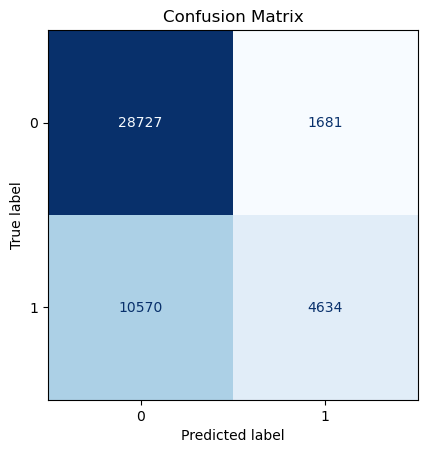

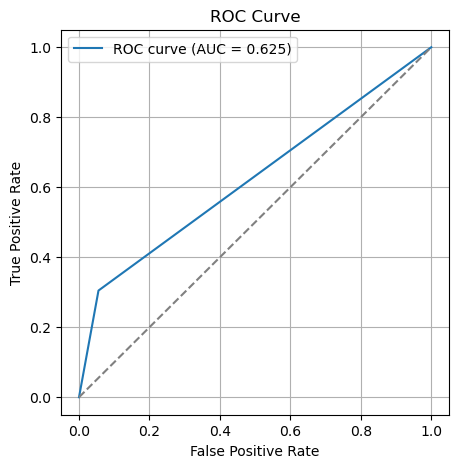

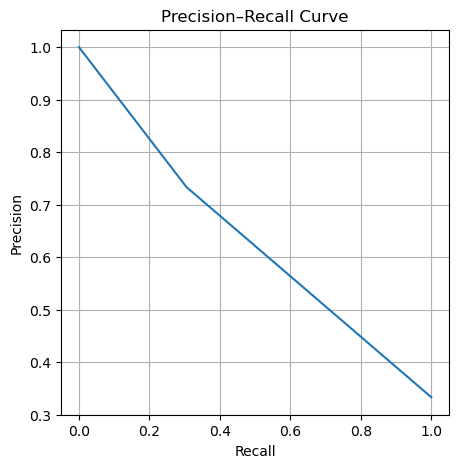

Epoch 3: Loss=0.4399, Test Acc=0.731


Evaluating:   0%|          | 13/5068 [00:00<01:23, 60.23it/s]

Predicted logits: [0.8303104  0.57200515 0.8876937  0.78153855 0.4587664  0.8231827
 0.6897763  0.79294926 0.77349615]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.83123446 0.5727448  0.88898325 0.7809819  0.45692438 0.8231993
 0.68880653 0.7934193  0.77327746]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.83126014 0.57228786 0.8900379  0.7787001  0.4527202  0.82214206
 0.68905133 0.7932467  0.7736207 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8305169  0.5716901  0.89045745 0.7756883  0.4488197  0.8206937
 0.6904291  0.7929836  0.7749952 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8294397  0.57018197 0.8895426  0.7727021  0.44515824 0.81828064
 0.6915531  0.7919536  0.7768461 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8279901  0.5671641  0.88763446 0.76887375 0.43958646 0.8140658
 0.6923868  0.7896978  0.77873814]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0

Evaluating: 100%|██████████| 5068/5068 [01:23<00:00, 60.51it/s]


1.797386950386226e-08 0.9959977865219116
0.0 1.0
Accuracy: 0.725, Precision: 0.653, Recall: 0.372, F1: 0.474, AUC: 0.637


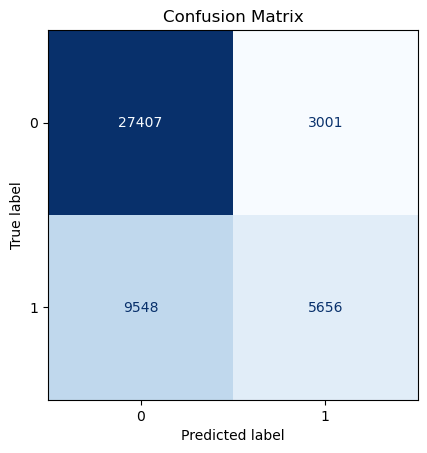

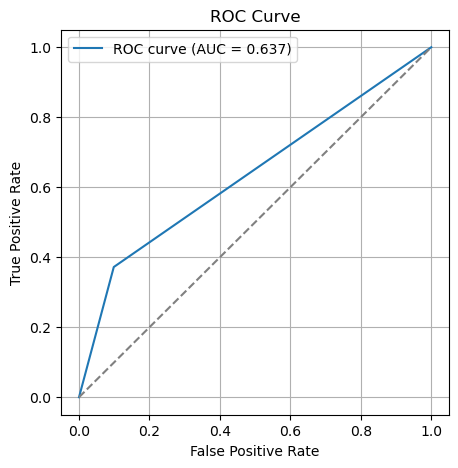

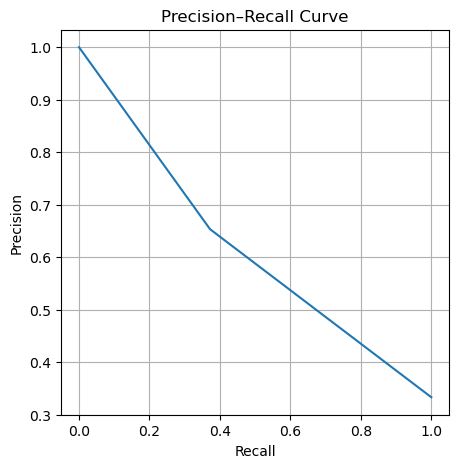

Epoch 4: Loss=0.4124, Test Acc=0.725


Evaluating:   0%|          | 7/5068 [00:00<01:23, 60.85it/s]

Predicted logits: [0.8493579  0.5577519  0.9106141  0.7973712  0.42573416 0.8459365
 0.65739495 0.8216423  0.78203785]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.85040843 0.558645   0.91191345 0.7980282  0.42540342 0.84700555
 0.6560751  0.8221448  0.7818753 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.85059047 0.55839354 0.9131023  0.797289   0.4232095  0.84745485
 0.6564073  0.82200295 0.7824342 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.85011786 0.55844176 0.91378933 0.795236   0.420722   0.847102
 0.65817636 0.8218498  0.7841744 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.849687   0.55808204 0.91335964 0.79287034 0.41791904 0.84534466
 0.65989864 0.82118124 0.7866451 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.84914327 0.5563402  0.91213506 0.7903323  0.41385832 0.8422819
 0.661643   0.8194837  0.7894732 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0

Evaluating: 100%|██████████| 5068/5068 [01:26<00:00, 58.43it/s]


3.0421101748778767e-10 0.9970372915267944
0.0 1.0
Accuracy: 0.739, Precision: 0.637, Recall: 0.503, F1: 0.562, AUC: 0.680


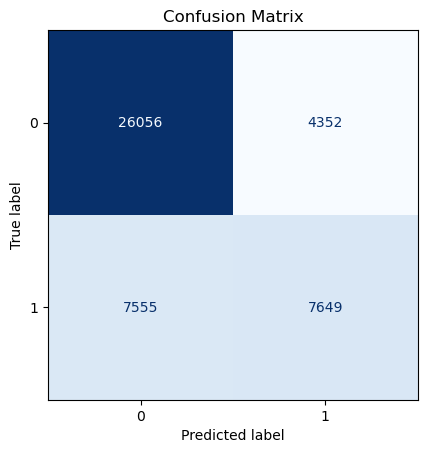

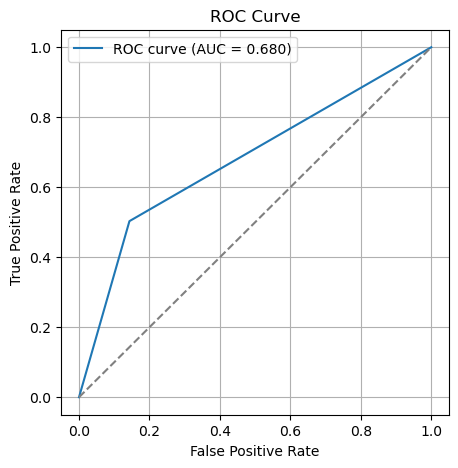

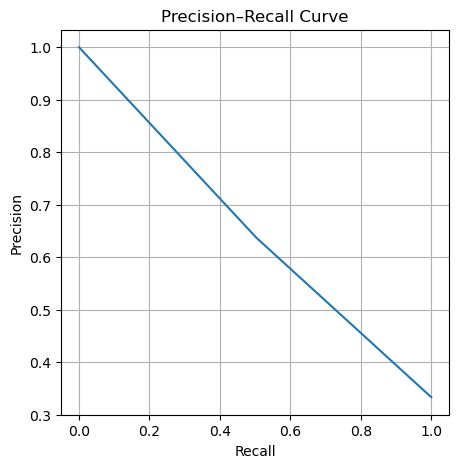

Epoch 5: Loss=0.3999, Test Acc=0.739


Evaluating:   0%|          | 13/5068 [00:00<01:23, 60.44it/s]

Predicted logits: [0.88071454 0.61771715 0.93981296 0.8536802  0.5113077  0.90160173
 0.63165337 0.8704146  0.8024079 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8816414  0.61878157 0.9408854  0.8545939  0.51181024 0.9027765
 0.6298484  0.8708801  0.8023848 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8819049  0.618868   0.94189256 0.8546054  0.5107312  0.90361845
 0.6300972  0.87079555 0.80296534]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.88165075 0.61941195 0.9425454  0.85329694 0.50888705 0.9037169
 0.6317347  0.87056506 0.80452687]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8813997  0.61950743 0.9423576  0.8512998  0.50593704 0.90254337
 0.6326741  0.86974585 0.8066284 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8810397  0.61821043 0.9415686  0.84919536 0.50173974 0.9004438
 0.63337195 0.86801356 0.8090226 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [

Evaluating: 100%|██████████| 5068/5068 [01:22<00:00, 61.08it/s]


1.3662776639222773e-11 0.9965919256210327
0.0 1.0
Accuracy: 0.748, Precision: 0.624, Recall: 0.614, F1: 0.619, AUC: 0.715


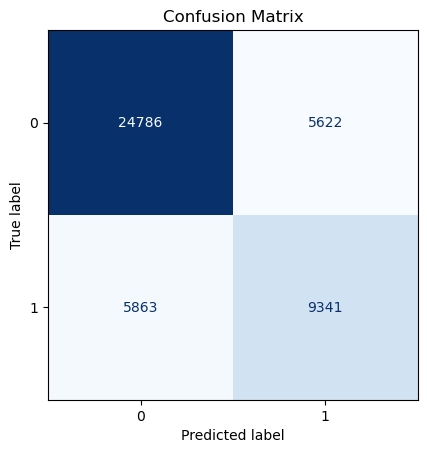

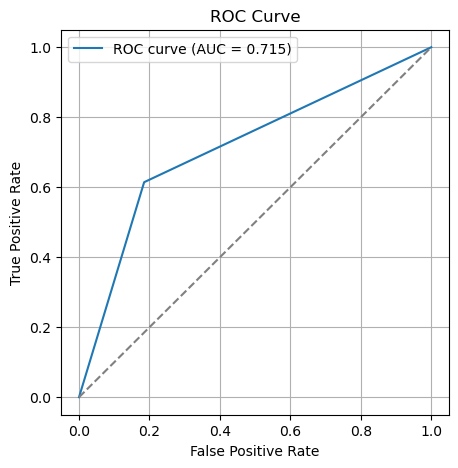

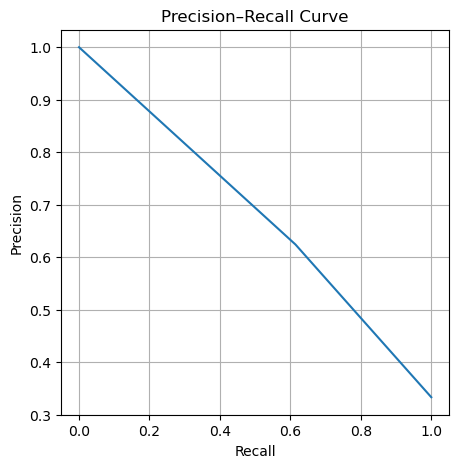

Epoch 6: Loss=0.3737, Test Acc=0.748


Evaluating:   0%|          | 13/5068 [00:00<01:24, 59.55it/s]

Predicted logits: [0.8737062  0.553782   0.93626785 0.8464949  0.44180942 0.89369196
 0.5597897  0.85046005 0.7735875 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8747264  0.5548966  0.93740356 0.8477142  0.44267863 0.89506495
 0.5575472  0.8509785  0.77331024]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.87503326 0.55503815 0.9385082  0.8480453  0.4421403  0.8961706
 0.5578474  0.85086066 0.77380615]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.87480736 0.5558242  0.93926746 0.8468629  0.44073698 0.8964519
 0.5598708  0.8506089  0.77563226]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8746879  0.55637205 0.9391633  0.84491366 0.43824252 0.8953622
 0.561224   0.8497742  0.7784423 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.87453437 0.5555654  0.93844765 0.8430418  0.43479502 0.8933905
 0.56254005 0.84795856 0.7819234 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0

Evaluating: 100%|██████████| 5068/5068 [01:23<00:00, 60.96it/s]


3.5120061223884065e-15 0.9997215867042542
0.0 1.0
Accuracy: 0.748, Precision: 0.623, Recall: 0.618, F1: 0.621, AUC: 0.716


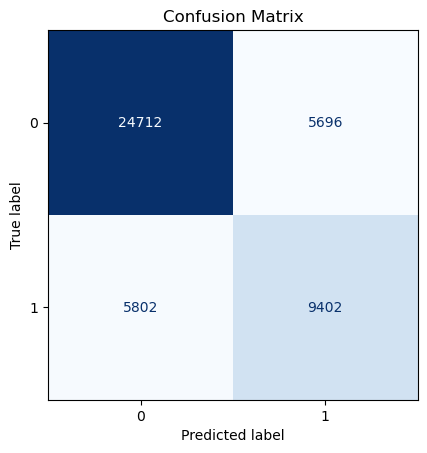

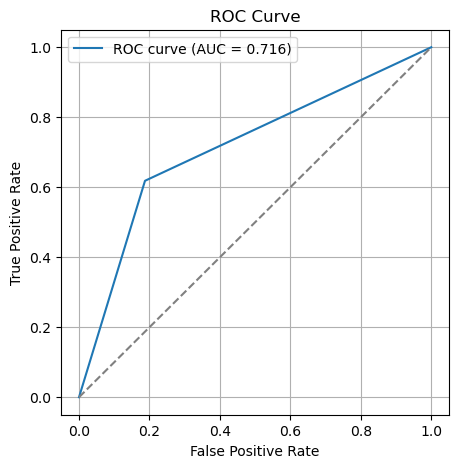

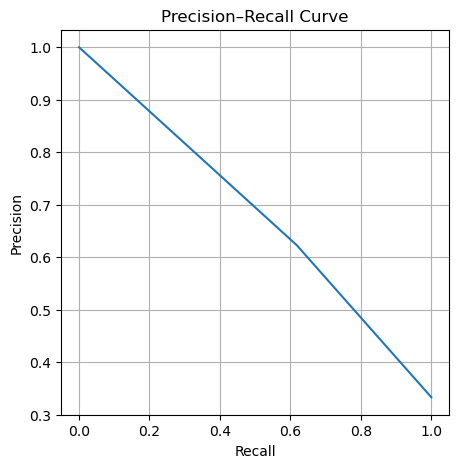

Epoch 7: Loss=0.3697, Test Acc=0.748


Evaluating:   0%|          | 12/5068 [00:00<01:28, 57.03it/s]

Predicted logits: [0.87738395 0.58419836 0.950564   0.8659328  0.49782652 0.92349976
 0.5672976  0.8780312  0.82769424]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.87849873 0.5853828  0.9516667  0.8679448  0.500483   0.9252786
 0.56501836 0.87854135 0.8279557 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8788037  0.58544624 0.95273364 0.86940706 0.50233066 0.9270396
 0.5653992  0.87844735 0.8288344 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8785053  0.58628017 0.9534521  0.8688647  0.5022077  0.9277588
 0.5672655  0.8781865  0.8305293 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8784683  0.5870417  0.953386   0.8669704  0.49939835 0.9268708
 0.56840706 0.8774357  0.83276546]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.87852275 0.58648026 0.95279616 0.8653891  0.4958656  0.925334
 0.5697951  0.8759023  0.8355832 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.8

Evaluating: 100%|██████████| 5068/5068 [01:24<00:00, 60.05it/s]


3.5448518577972654e-13 0.9999008178710938
0.0 1.0
Accuracy: 0.748, Precision: 0.612, Recall: 0.661, F1: 0.636, AUC: 0.726


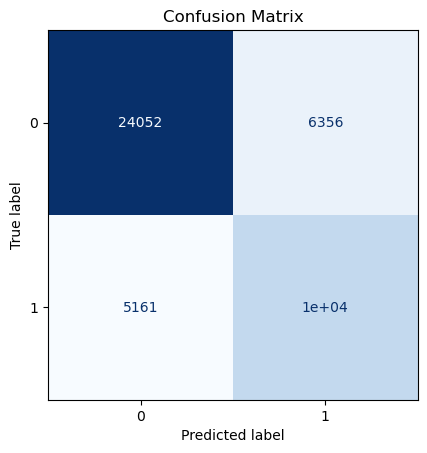

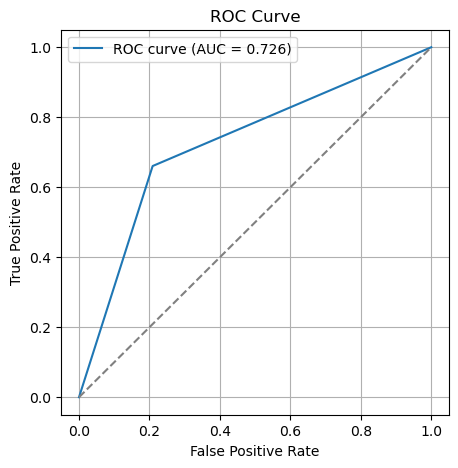

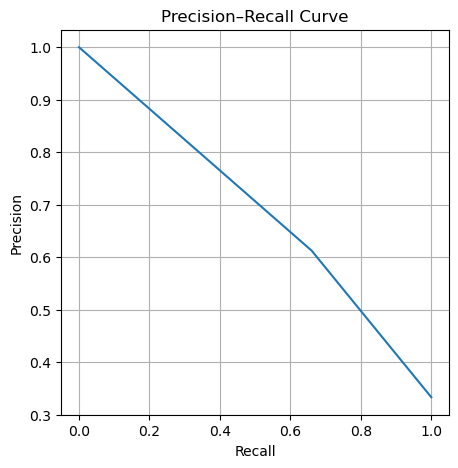

Epoch 8: Loss=0.3653, Test Acc=0.748


Evaluating:   0%|          | 12/5068 [00:00<01:26, 58.69it/s]

Predicted logits: [0.9461166  0.81278497 0.97045994 0.9520014  0.5997096  0.8879571
 0.7507115  0.93002707 0.7619719 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.9467991  0.8136179  0.9708411  0.95205563 0.59885347 0.8884044
 0.74684286 0.92982936 0.7568211 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.94686407 0.8131547  0.97107905 0.9514913  0.59503424 0.88805497
 0.7457463  0.9294465  0.7529381 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.9464706  0.81222725 0.97103214 0.9500083  0.5886043  0.88631445
 0.74735326 0.9291461  0.75286233]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.9462165  0.8099271  0.9704705  0.94784135 0.5796224  0.88264745
 0.7488354  0.928904   0.7575261 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.9460134  0.80558044 0.9695374  0.9454647  0.56880796 0.8775926
 0.7505823  0.9284505  0.7651162 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [

Evaluating: 100%|██████████| 5068/5068 [01:24<00:00, 60.13it/s]


2.946931327435509e-12 0.9977076053619385
0.0 1.0
Accuracy: 0.765, Precision: 0.633, Recall: 0.705, F1: 0.667, AUC: 0.750


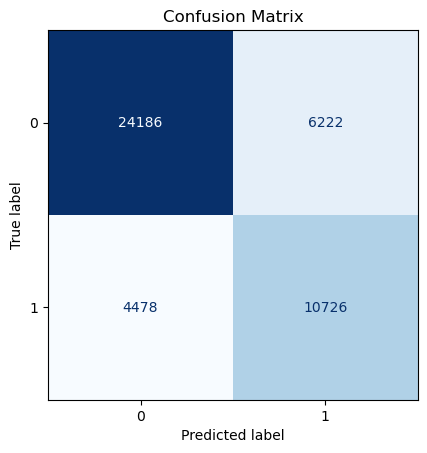

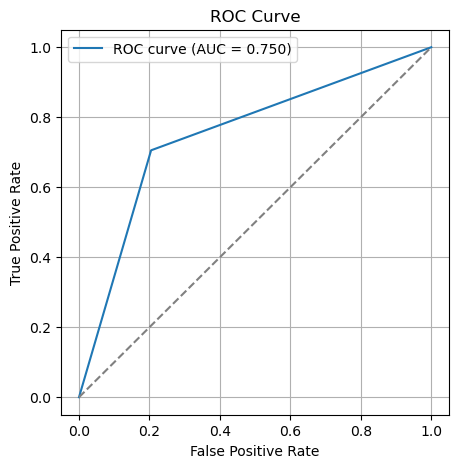

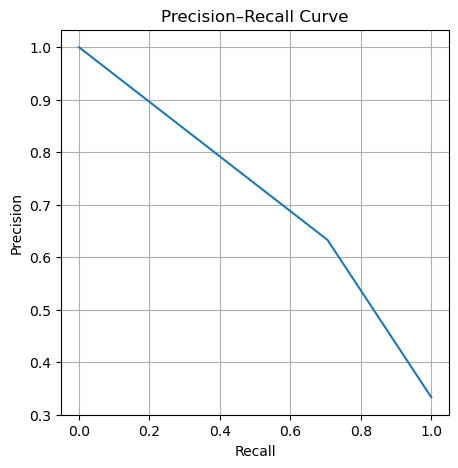

Epoch 9: Loss=0.3571, Test Acc=0.765


Evaluating:   0%|          | 12/5068 [00:00<01:26, 58.46it/s]

Predicted logits: [0.9489831  0.5989298  0.9162238  0.86554146 0.27476278 0.70574844
 0.5719988  0.862398   0.51084477]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.94919825 0.5991754  0.9173221  0.8662637  0.274998   0.70771635
 0.56743354 0.862524   0.508329  ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.94880927 0.5972036  0.9181129  0.8656547  0.27320608 0.70846564
 0.56533307 0.8615069  0.5063076 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.94793946 0.59481245 0.9182172  0.862473   0.26893407 0.70594156
 0.56403106 0.85956365 0.5055865 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.9469573  0.59154916 0.9170186  0.8573988  0.26239341 0.69915295
 0.56049687 0.856585   0.50659937]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits: [0.9459044  0.5866217  0.9149021  0.852208   0.25505787 0.6902183
 0.5565148  0.8524154  0.5091329 ]
Actual labels: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Predicted logits:

Evaluating: 100%|██████████| 5068/5068 [01:23<00:00, 60.36it/s]


1.6424056125535769e-12 0.9998242259025574
0.0 1.0
Accuracy: 0.772, Precision: 0.635, Recall: 0.742, F1: 0.684, AUC: 0.764


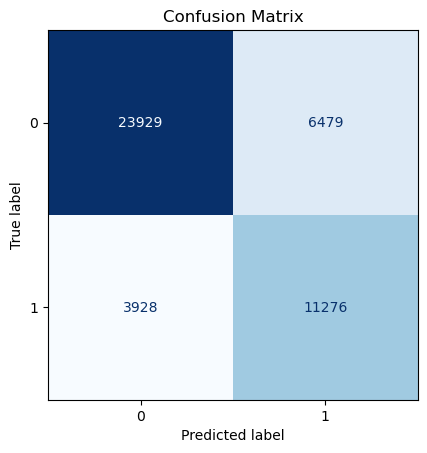

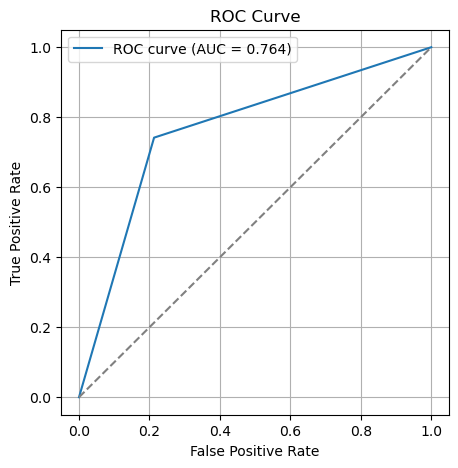

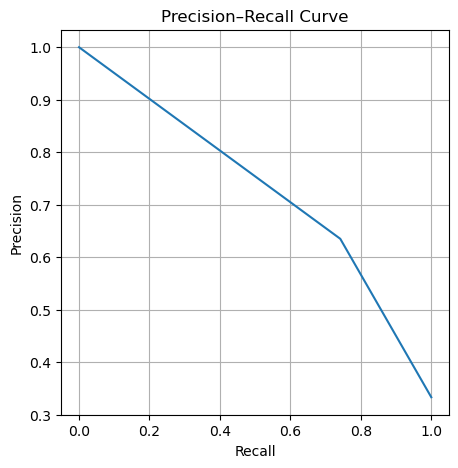

Epoch 10: Loss=0.3561, Test Acc=0.772


In [13]:
# Load pretrained trajectory model
model_traj, config = load_pretrained_traj_model(experiment_dir, device)
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Initialize new relation model
relation_model = DroneRelationModel(context_dim=model_traj.dec_hidden_size).to(device)
# relation_model = DroneRelationModel(
#     context_dim=model_traj.enc_hidden_size * 2,
# ).to(device)

# optimizer = optim.Adam(relation_model.parameters(), lr=1e-3)
optimizer = optim.Adam(
    [
        {"params": relation_model.parameters(), "lr": 1e-4},
        {"params": model_traj.parameters(), "lr": 1e-4},
    ]
)
# pos_weight = torch.tensor([2.0], device=device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()

criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):
    loss = train_epoch(
        relation_model, train_ds, optimizer, criterion, scaler_X, model_traj, config
    )
    acc = evaluate(relation_model, test_ds, scaler_X, model_traj, config)
    print(f"Epoch {epoch + 1}: Loss={loss:.4f}, Test Acc={acc:.3f}")


# # Load pretrained trajectory model
# model_traj, config = load_pretrained_traj_model(experiment_dir, device)
# scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# # Initialize VGAE model (instead of DroneRelationModel)
# vgae_model = VGAE(
#     in_dim=model_traj.dec_hidden_size,  # same as your current context_dim
#     hidden_dim=128,
#     latent_dim=64,
#     decoder_type="dot",  # or "bilinear" for directed
#     device=device
# ).to(device)

# optimizer = torch.optim.Adam([
#     {"params": vgae_model.parameters(), "lr": 1e-4},
#     {"params": model_traj.parameters(), "lr": 1e-4},
# ])

# # Training loop
# for epoch in range(10):
#     loss = train_epoch_vgae(vgae_model, train_ds, optimizer, scaler_X, model_traj, config, device)
#     acc = evaluate_vgae(vgae_model, test_ds, scaler_X, model_traj, config, device)
#     print(f"Epoch {epoch+1}: Loss={loss:.4f}, Test Acc={acc:.3f}")